# Testing integrated normal flux

In [23]:
import numpy as np
import timml as tml
import matplotlib.pyplot as plt

## Uniform flow field

Some sanity checks in a uniform flow field

Number of elements, Number of equations: 2 , 1
..
solution complete


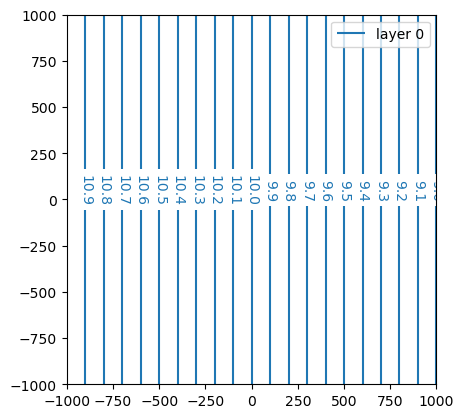

In [24]:
slope = 0.001

ml = tml.ModelMaq()
u = tml.Uflow(ml, slope, angle=0.0)
c = tml.Constant(ml, 0.0, 0.0, 10)
ml.solve()
ml.contour([-1000, 1000, -1000, 1000], decimals=1);

45-degree line between (-10, -10) and (10, 10), should equal L * cos(theta) * slope.

In [30]:
x1, y1 = -10.0, -10.0
x2, y2 = 10.0, 10.0
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
theta = np.arctan2(y2 - y1, x2 - x1)

qn_quad = ml.intnormflux(x1, x2, y1, y2, method="quad")
qn_leg = ml.intnormflux(x1, x2, y1, y2, method="legendre", ndeg=3)

print(qn_quad, qn_leg, L * np.cos(theta) * slope)

[0.02] [0.02] 0.020000000000000004


Line normal to uniform flow should equal L * slope

In [29]:
x1, y1 = 0.0, -10.0
x2, y2 = 0.0, 10.0
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

qn_quad = ml.intnormflux(x1, x2, y1, y2, method="quad")
qn_leg = ml.intnormflux(x1, x2, y1, y2, method="legendre", ndeg=3)

print(qn_quad, qn_leg, L * slope)

[0.02] [0.02] 0.02


Line parallel to uniform flow direction should equal 0.0

In [31]:
x1, y1 = -10.0, 0.0
x2, y2 = 10.0, 0.0

qn_quad = ml.intnormflux(x1, x2, y1, y2, method="quad")
qn_leg = ml.intnormflux(x1, x2, y1, y2, method="legendre", ndeg=3)

print(qn_quad, qn_leg, 0.0)

[1.2246468e-18] [1.2246468e-18] 0.0


## Two layer confined model with well

Integration along some shape around well should equal $Q_w$.

Number of elements, Number of equations: 2 , 1
..
solution complete


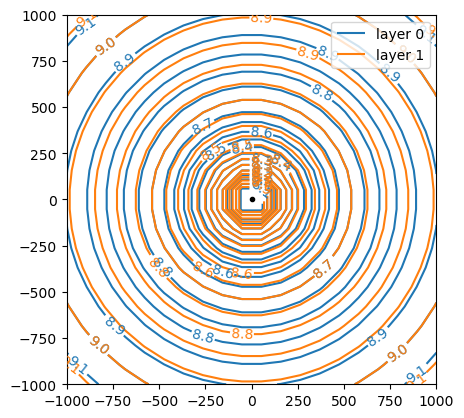

In [6]:
ml = tml.ModelMaq(kaq=[5.0, 10.0], z=[0, -10, -15, -30], c=[100])
c = tml.Constant(ml, 1e4, 1e4, 10)
w = tml.Well(ml, 0.0, 0.0, Qw=500, layers=[1])
ml.solve()
ml.contour([-1000, 1000, -1000, 1000], layers=[0, 1], decimals=1);

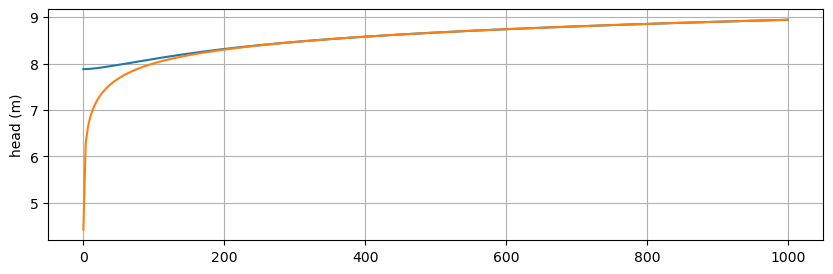

In [7]:
xl = np.linspace(0.1, 1000, 301)
yl = np.zeros_like(xl)

h = ml.headalongline(xl, yl)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(xl, h[0], color="C0")
ax.plot(xl, h[1], color="C1")
ax.set_ylabel("head (m)")
ax.grid(True)

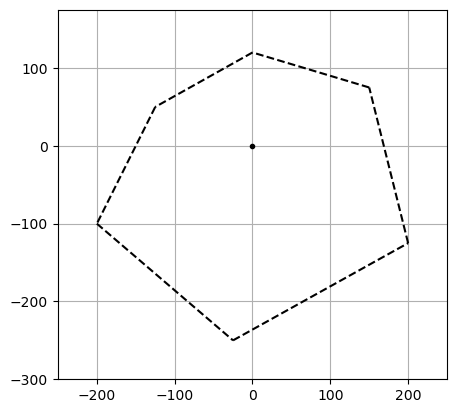

In [22]:
xy = [
    (-200, -100),
    (-25, -250),
    (200, -125),
    (150, 75),
    (0, 120),
    (-125, 50),
    (-200, -100),
]

window = [-250, 250, -300, 175]
ml.plot(window)
for i in range(len(xy)-1):
    xyi = np.array(xy[i:i + 2])
    plt.plot(xyi[:, 0], xyi[:, 1], ls="dashed", color="k")
plt.grid(True)

Integration along each edge with both methods, quad and legendre, equals $Q_w$.

In [14]:
Qn_quad = np.zeros(ml.aq.naq)
Qn_leg = np.zeros(ml.aq.naq)

for i in range(len(xy) - 1):
    x1, y1 = xy[i]
    x2, y2 = xy[i + 1]

    qni_quad = ml.intnormflux(x1, x2, y1, y2, method="quad")
    qni_leg = ml.intnormflux(x1, x2, y1, y2, method="legendre", ndeg=7)

    Qn_quad += qni_quad
    Qn_leg += qni_leg

print("Q (quad)    :", Qn_quad.sum())
print("Q (legendre):", Qn_leg.sum())

Q (quad)    : -500.0
Q (legendre): -500.0000023231959
